In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
from collections import Counter
%matplotlib inline
import nltk
from nltk.corpus import stopwords
!pip install --upgrade gensim
import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import LdaModel, CoherenceModel
from gensim.models.phrases import Phrases, Phraser
from gensim.models import Nmf
import re
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import NMF
from operator import itemgetter

!pip install bitermplus
!pip install tmplot
import bitermplus as btm
import tmplot as tmp
import warnings
warnings.filterwarnings('ignore')
nltk.download('stopwords')


from nltk.stem.wordnet import WordNetLemmatizer
import spacy

from pprint import pprint
!pip install little-mallet-wrapper
import little_mallet_wrapper as lmw

#pd.set_option("display.max_rows", None, "display.max_columns", None) #to show everything 
stop_words = stopwords.words('english')
nlp = spacy.load('en_core_web_sm') 
nlp.disable_pipes('ner', 'parser')


     |████████████████████████████████| 24.1 MB 59.6 MB/s 
  Attempting uninstall: gensim
    Found existing installation: gensim 3.6.0
    Uninstalling gensim-3.6.0:
      Successfully uninstalled gensim-3.6.0
     |████████████████████████████████| 614 kB 5.5 MB/s 
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
  Created wheel for bitermplus: filename=bitermplus-0.6.10-cp37-cp37m-linux_x86_64.whl size=931254 sha256=9514306bbcc7cc9cf7f2ace4297e65936b6c8912cb07537eea8c26ae06d68ef8
  Stored in directory: /root/.cache/pip/wheels/2b/1a/8d/58328971ebe27f346b2e0c05ea9fe45bc67986310557074141
Successfully built bitermplus
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
     |████████████████████████████████| 16.3 MB 5.1 MB/s 
  Created wheel for tmplot: filename=tmplot-0.0.5-py3-none-any.whl size=13967 sha256=51568b072c1bfa6fb465b99321884

[('ner', <spacy.pipeline.pipes.EntityRecognizer at 0x7f2a6d535830>),
 ('parser', <spacy.pipeline.pipes.DependencyParser at 0x7f2a6d535750>)]


# Part A: Clean and organize all the text files  
1. Create seperate variables and dataframes for each of the books in case you want to conduct book level analysis   
2. Create a combined dataframe of all the text for overall analysis - include some meta data on book


In [ ]:
file_names = ['1 the duke and i.txt', '2 the viscount who loved me.txt', '3 an offer from a gentleman.txt', 
             '4 romancing mister brigerton.txt', '5 to sir phillip, with love.txt', '6 when he was wicked.txt', 
             '7 its in his kiss.txt', '8 on the way to the wedding.txt']

bk_dfs = []

In [ ]:
def bk_to_df(filename): 
    '''
    takes in text file
    returns text in dataframe with each row containing chapter text
    '''
    
    with open(filename, encoding='utf8') as file: 
        bk = file.read()
    
    bk = bk.replace('\n',' ')
    bk = bk.replace('\t',' ')
    split_bk =bk.split('\x0cChapter_')
    split_bk = [text.replace('\x0c', '') for text in split_bk]
    
    chaptnum = len(split_bk)-1
    #print(chaptnum)
    
    title = split_bk[0].strip()
    #print(title)
        
    bk_df = pd.DataFrame(np.arange(chaptnum), columns = ['chapter'])
    bk_df['text'] = split_bk[1:]
    bk_df['title'] = title.lower()
    bk_df['book_num']= int(filename[0])
    
    bk_df = bk_df[['book_num', 'title', 'chapter', 'text']]
    #display(bk_df)
    return bk_df
    

In [ ]:
for i in file_names: 
    bk_dfs.append(bk_to_df(i))

In [ ]:
#dataframes of individual books (not really needed)
bk1 = bk_dfs[0]
bk2 = bk_dfs[1]
bk3 = bk_dfs[2]
bk4 = bk_dfs[3]
bk5 = bk_dfs[4]
bk6 = bk_dfs[5]
bk7 = bk_dfs[6]
bk8 = bk_dfs[7]

In [ ]:
all_bks_df = pd.concat(bk_dfs)
#all_bks_df.to_csv('all text.csv')
all_bks_df

book_num  ...                                               text
0          1  ...   0 Prologue_ The birth of Simon Arthur Henry F...
1          1  ...   1 The Bridgertons are by far the most prolifi...
2          1  ...   2 The new Duke of Hastings is a most interest...
3          1  ...   3 It has been whispered to This Author that N...
4          1  ...   4  London is awash these days with Ambitious ...
..       ...  ...                                                ...
22         8  ...   22        In which all hell breaks loose.    ...
23         8  ...   23        In which Our Hero risks everything....
24         8  ...   24        In which Our Hero leaves Our Heroin...
25         8  ...   25        In which we learn what happened, a ...
26         8  ...   26 Epilogue        In which Our Hero and Hero...

[193 rows x 4 columns]

# Part B: Exploratory Data Analysis of Text  (before text cleaning)
Exploring trends in word length by chapter and by book

In [ ]:
#get number of words in each chapter 
all_bks_df['num_words'] = all_bks_df['text'].map(lambda x: x.split()).str.len()
all_bks_df

book_num  ... num_words
0          1  ...      3238
1          1  ...      3895
2          1  ...      4994
3          1  ...      5524
4          1  ...      4250
..       ...  ...       ...
22         8  ...      2292
23         8  ...      2495
24         8  ...      4637
25         8  ...      4628
26         8  ...       903

[193 rows x 5 columns]

In [ ]:
#average word count in chapter 
display(all_bks_df['num_words'].describe())

count     193.000000
mean     4029.512953
std      1096.762908
min       239.000000
25%      3555.000000
50%      4143.000000
75%      4719.000000
max      6371.000000
Name: num_words, dtype: float64

In [ ]:
#mode of chapter word count
all_bks_df['num_words'].mode()

0    4103
dtype: int64

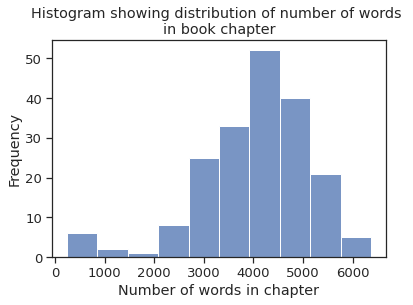

In [ ]:
#word count distribution among book chapters
sns.histplot(data= all_bks_df['num_words'], bins= 10, palette="Blues_d")
plt.title('Histogram showing distribution of number of words \nin book chapter')
plt.xlabel('Number of words in chapter')
plt.ylabel('Frequency')

plt.show()

book_num                        title  chapter  num_words
0         1               the duke and i       23      96969
1         2    the viscount who loved me       24     104970
2         3    an offer from a gentleman       25      99478
3         4  romancing mister bridgerton       25     103155
4         5    to sir phillip, with love       21      91089
5         6           when he was wicked       25      90309
6         7             it's in his kiss       23      89877
7         8    on the way to the wedding       27     101849

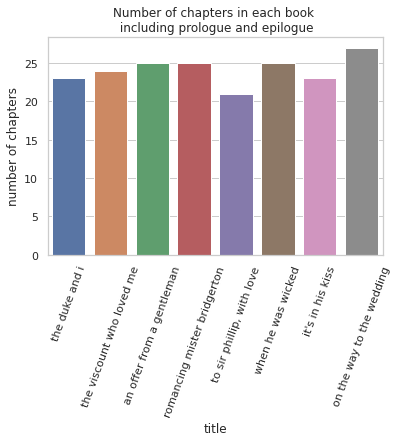

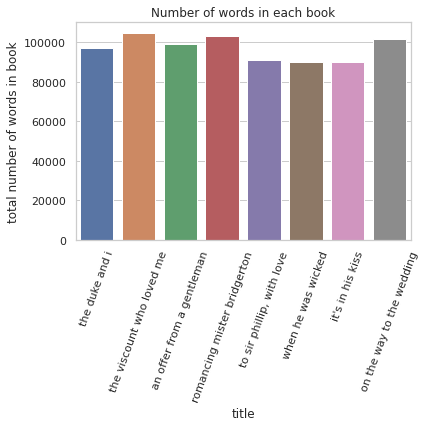

In [ ]:
#book chapter analysis
bk_words = pd.DataFrame(all_bks_df.groupby(by=['book_num', 'title']).sum()['num_words'])


bk_chapts = pd.DataFrame(all_bks_df.groupby(by=['book_num', 'title']).count()['chapter'])

bk_details = pd.concat([bk_chapts, bk_words], axis= 1)
bk_details = bk_details.reset_index()

display(bk_details)


sns.set_theme(style="whitegrid")
sns.barplot(data=bk_details, x='title', y='chapter')
plt.ylabel('number of chapters')
plt.title('Number of chapters in each book \n including prologue and epilogue')
plt.xticks(rotation=70)

plt.show()

sns.barplot(data=bk_details, x='title', y='num_words')
plt.ylabel('total number of words in book')
plt.title('Number of words in each book')
plt.xticks(rotation=70)

plt.show()


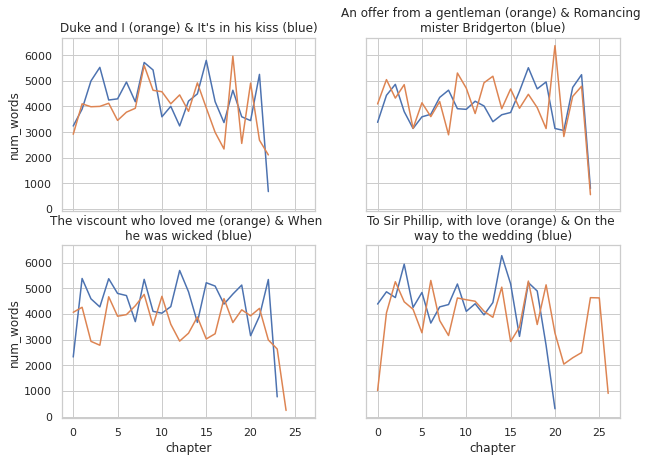

In [ ]:
#Analysis into number of words in chapters
#books roughly grouped by similar number of chapters with the exception of the last graph on the bottom right

fig, axes = plt.subplots(2, 2, sharex=True, sharey=True, figsize=(10,7))


axes[0,0].set_title('Duke and I (orange) & It\'s in his kiss (blue)')
axes[0,1].set_title('An offer from a gentleman (orange) & Romancing \nmister Bridgerton (blue)')
axes[1,0].set_title('The viscount who loved me (orange) & When \nhe was wicked (blue)')
axes[1,1].set_title('To Sir Phillip, with love (orange) & On the \nway to the wedding (blue)')

for i in [1,7]: 
    bk_words = all_bks_df[all_bks_df['book_num'] == i][['chapter','num_words']]
    ax1 = sns.lineplot(ax=axes[0, 0], data=bk_words, x='chapter', y='num_words')

for i in [3, 4]: 
    bk_words = all_bks_df[all_bks_df['book_num'] == i][['chapter','num_words']]
    ax2 = sns.lineplot(ax=axes[0, 1], data=bk_words, x='chapter', y='num_words')

for i in [2,6]: 
    bk_words = all_bks_df[all_bks_df['book_num'] == i][['chapter','num_words']]
    ax3 = sns.lineplot(ax=axes[1, 0], data=bk_words, x='chapter', y='num_words')

for i in [5,8]: 
    bk_words = all_bks_df[all_bks_df['book_num'] == i][['chapter','num_words']]
    ax4 = sns.lineplot(ax=axes[1, 1], data=bk_words, x='chapter', y='num_words')



# Part C: Text preprocessing & EDA of preprocessed text
Remove stopwords, lemmatize words, create words clouds 

In [ ]:
all_bks_df.head(2)

book_num  ... num_words
0         1  ...      3238
1         1  ...      3895

[2 rows x 5 columns]

In [ ]:
#remove punctuation and change text to lower case 
all_bks_df['text'] = \
all_bks_df['text'].map(lambda x: re.sub('[,\.!?]', '', x))
all_bks_df['text'] = \
all_bks_df['text'].map(lambda x: x.lower())
all_bks_df['text'].head()

data = all_bks_df.text.values.tolist() 

In [ ]:
#functions to use to clean text
stop_words = stopwords.words('english')

def sent_to_words(sentences): 
    '''
    creates list of words and removes punctuation
    '''
    for sentence in sentences: 
        yield(gensim.utils.simple_preprocess(str(sentence), deacc=True))
        
def remove_stopwords(texts):
    return [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in texts]

def lemmatization(texts, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']):
    texts_out = []
    for sent in texts:
        doc = nlp(" ".join(sent)) 
        texts_out.append([token.lemma_ for token in doc if token.pos_ in allowed_postags])
    return texts_out

In [ ]:
data_words = list(sent_to_words(data))
data_words_nostops = remove_stopwords(data_words)
data_lemmatized = lemmatization(data_words_nostops, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV'])

With stop words, punctuation removed and noun/adjectives/verbs/adverbs lemmatized, I now create a word cloud to observe the frequently occurring words in the entire dataset

In [ ]:
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator

def gen_wordcloud(data, remove_names):
    
    if remove_names: 
        stopwords = ['anthony', 'benedict', 'colin', 'daphne', 'eloise', 'francesca', 'gregory', 'hyacinth', 
                     'brigerton', 'penelope', 'whistledown', 'kate', 'violet', 'marina', 'simon', 'phillip', 'sophie'] #names from google results for brigerton characters
        
    else: 
        stopwords = ''
        
    cloudwords = [j for i in data for j in i]
    cloudwords = ' '.join(cloudwords)
    
    w = WordCloud(background_color= "white", stopwords=stopwords, height=1000, width= 1700,max_words=200, min_font_size = 8)
    w.generate(cloudwords)

    plt.figure(figsize = (10, 5)) 
    plt.imshow(w, interpolation="bilinear")
    plt.axis("off")
    plt.show()

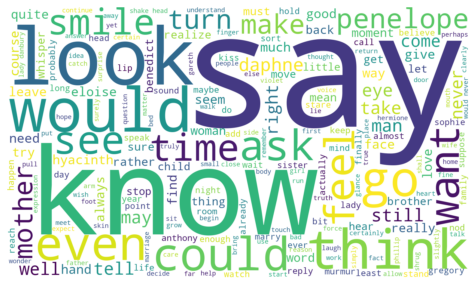

In [ ]:
gen_wordcloud(data_lemmatized, False)

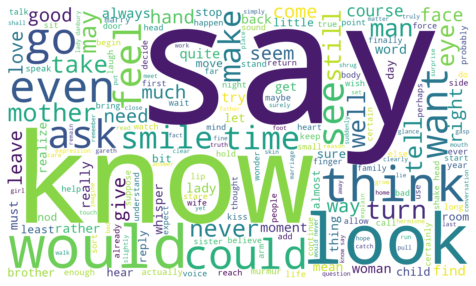

In [ ]:
gen_wordcloud(data_lemmatized, True) #names removed

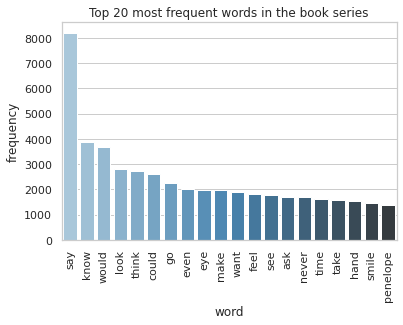

In [ ]:
all_words_bkseries = [j for i in data_lemmatized for j in i] #in list format

top_20 = pd.DataFrame(Counter(all_words_bkseries).most_common(20), columns=['word', 'frequency'])


sns.set_theme(style="whitegrid")
sns.barplot(x='word', y='frequency', data=top_20, palette="Blues_d")
plt.title('Top 20 most frequent words in the book series')
plt.xticks(rotation=90)

plt.show()

In [ ]:
#some variables that will be useful

all_words = ' '.join(all_words_bkseries) #all words in the book series in string format 

key_names = ['anthony', 'benedict', 'colin', 'daphne', 'eloise', 'francesca', 'gregory', 'hyacinth', 'bridgerton', 'penelope', 'gareth', 'hermione',
             'whistledown', 'kate', 'violet', 'marina', 'simon', 'phillip', 'sophie', 'danbury', 'lucinda', 'felicity', 'penwood', 'posy']

In [ ]:
#number of unique words in book series after preprocessing 
len(set(all_words_bkseries))
len(all_words)

1926311

# Part D: Find optimal number of topics by plotting divergence between Jaccard similarity and Coherence for LDA model
using code from: https://stackoverflow.com/questions/32313062/what-is-the-best-way-to-obtain-the-optimal-number-of-topics-for-a-lda-model-usin  

In [ ]:
def jaccard_similarity(topic_1, topic_2):
    """
    Derives the Jaccard similarity of two topics

    Jaccard similarity:
    - A statistic used for comparing the similarity and diversity of sample sets
    - J(A,B) = (A ∩ B)/(A ∪ B)
    - Goal is low Jaccard scores for coverage of the diverse elements
    """
    intersection = set(topic_1).intersection(set(topic_2))
    union = set(topic_1).union(set(topic_2))
                    
    return float(len(intersection))/float(len(union))


ideal_topic_num (when maxing divergence): 14
mean_stabilities: [0.7708333333333333, 0.5687134502923976, 0.47767436494048426, 0.36199388045211844, 0.35987906680597487, 0.4325622627864806, 0.3970543852352354, 0.345355569411532, 0.293987332330622, 0.3475285941607907, 0.3884961314155702, 0.4033491832000718, 0.40788109430432146, 0.3000867990667502]
coherences: [0.2274905734052442, 0.22479965442110356, 0.24294395109729175, 0.258270297587453, 0.29035520455486663, 0.23409234058981446, 0.24894492816999442, 0.2573690004148152, 0.2516940750408296, 0.24595402255653384, 0.23725355237973947, 0.23323567097109563, 0.24699318573422152, 0.2608535726052238]
perplexities: [-7.334641232735188, -7.335440808187617, -7.326410048390454, -7.338340771583002, -7.330403567257723, -7.366075467411883, -7.366245023806087, -7.335133042982832, -7.369316602738229, -7.3577438268584885, -7.373380793879409, -7.357426532658806, -7.378022700018942, -7.361653122065927]


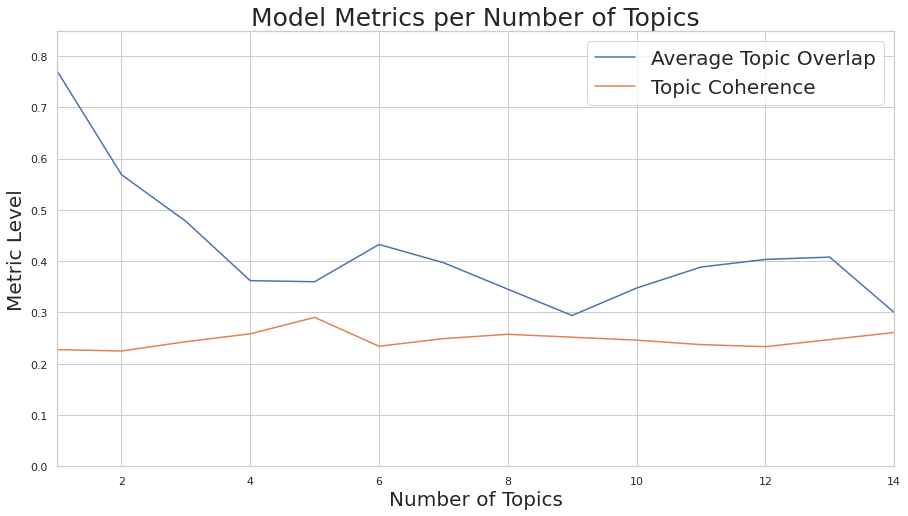

In [ ]:
def opt_topic_num_lda(id2word, bow_corpus):
  '''
  function to find optimal topic number for lda model
  '''
  # Considering 1-15 topics, as the last is cut off
  num_topics = list(range(16)[1:])
  num_keywords = 15

  LDA_models = {}
  LDA_topics = {}
  for i in num_topics:
      LDA_models[i] = LdaModel(corpus=bow_corpus,
                              id2word=id2word,
                              num_topics=i,
                              update_every=1,
                              chunksize=len(bow_corpus),
                              passes=20,
                              alpha='auto')

      shown_topics = LDA_models[i].show_topics(num_topics=i, 
                                              num_words=num_keywords,
                                              formatted=False)
      LDA_topics[i] = [[word[0] for word in topic[1]] for topic in shown_topics]
  LDA_stability = {}
  for i in range(0, len(num_topics)-1):
      jaccard_sims = []
      for t1, topic1 in enumerate(LDA_topics[num_topics[i]]): # pylint: disable=unused-variable
          sims = []
          for t2, topic2 in enumerate(LDA_topics[num_topics[i+1]]): # pylint: disable=unused-variable
              sims.append(jaccard_similarity(topic1, topic2))    
          
          jaccard_sims.append(sims)    
      
      LDA_stability[num_topics[i]] = jaccard_sims
                  
  mean_stabilities = [np.array(LDA_stability[i]).mean() for i in num_topics[:-1]]

  coherences = [CoherenceModel(model=LDA_models[i], texts=data_lemmatized, dictionary=id2word, coherence='c_v').get_coherence()\
                for i in num_topics[:-1]]
  coh_sta_diffs = [coherences[i] - mean_stabilities[i] for i in range(num_keywords)[:-1]] # limit topic numbers to the number of keywords
  coh_sta_max = max(coh_sta_diffs)
  coh_sta_max_idxs = [i for i, j in enumerate(coh_sta_diffs) if j == coh_sta_max]
  ideal_topic_num_index = coh_sta_max_idxs[0] # choose less topics in case there's more than one max
  ideal_topic_num = num_topics[ideal_topic_num_index]

  perplexities = [LDA_models[i].log_perplexity(bow_corpus) for i in num_topics[:-1]]

  print('ideal_topic_num (when maxing divergence):', ideal_topic_num)
  print('mean_stabilities:', mean_stabilities)
  print('coherences:', coherences)
  print('perplexities:', perplexities)

  plt.figure(figsize=(15,8))
  ax = sns.lineplot(x=num_topics[:-1], y=mean_stabilities, label='Average Topic Overlap')
  ax = sns.lineplot(x=num_topics[:-1], y=coherences, label='Topic Coherence')

  #ax.axvline(x=ideal_topic_num, label='Ideal Number of Topics', color='black')
  #ax.axvspan(xmin=ideal_topic_num - 1, xmax=ideal_topic_num + 1, alpha=0.5, facecolor='grey')

  y_max = max(max(mean_stabilities), max(coherences)) + (0.10 * max(max(mean_stabilities), max(coherences)))
  ax.set_ylim([0, y_max])
  ax.set_xlim([1, num_topics[-1]-1])
                  
  ax.axes.set_title('Model Metrics per Number of Topics', fontsize=25)
  ax.set_ylabel('Metric Level', fontsize=20)
  ax.set_xlabel('Number of Topics', fontsize=20)
  plt.legend(fontsize=20)
  plt.show()   

#run function
id2word = corpora.Dictionary(data_lemmatized)
bow_corpus = [id2word.doc2bow(text) for text in data_lemmatized]
opt_topic_num_lda(id2word, bow_corpus)


# Part E: Find optimal number of topics by plotting divergence between Jaccard similarity and Coherence for NMF Model 

In [ ]:
def opt_topic_num_nmf(id2word, bow_corpus):

  num_topics = list(range(16)[1:])
  num_keywords = 15

  nmf_models = {}
  nmf_topics = {}
  for i in num_topics:
      nmf_models[i] = Nmf(
          corpus=bow_corpus,
          num_topics=i,
          id2word=id2word,
          chunksize=2000,
          passes=5,
          kappa=.1,
          minimum_probability=0.01,
          w_max_iter=300,
          w_stop_condition=0.0001,
          h_max_iter=100,
          h_stop_condition=0.001,
          eval_every=10,
          normalize=True
      )

      shown_topics = nmf_models[i].show_topics(num_topics=i, 
                                              num_words=num_keywords,
                                              formatted=False)
      nmf_topics[i] = [[word[0] for word in topic[1]] for topic in shown_topics]

  nmf_stability = {}
  for i in range(0, len(num_topics)-1):
      jaccard_sims = []
      for t1, topic1 in enumerate(nmf_topics[num_topics[i]]): # pylint: disable=unused-variable
          sims = []
          for t2, topic2 in enumerate(nmf_topics[num_topics[i+1]]): # pylint: disable=unused-variable
              sims.append(jaccard_similarity(topic1, topic2))    
          
          jaccard_sims.append(sims)    
      
      nmf_stability[num_topics[i]] = jaccard_sims
                  
  mean_stabilities = [np.array(nmf_stability[i]).mean() for i in num_topics[:-1]]

  coherences = [CoherenceModel(model=nmf_models[i], texts=data_lemmatized, dictionary=id2word, coherence='c_v').get_coherence() for i in num_topics[:-1]]

  coh_sta_diffs = [coherences[i] - mean_stabilities[i] for i in range(len(num_topics)-1)] 
  coh_sta_max = max(coh_sta_diffs)
  coh_sta_max_idxs = [i for i, j in enumerate(coh_sta_diffs) if j == coh_sta_max]
  ideal_topic_num_index = coh_sta_max_idxs[0] # choose less topics in case there's more than one max
  ideal_topic_num = num_topics[ideal_topic_num_index]

  print('ideal_topic_num (when maxing divergence):', ideal_topic_num)
  print('mean_stabilities:', mean_stabilities)
  print('coherences:', coherences)

  plt.figure(figsize=(20,10))
  ax = sns.lineplot(x=num_topics[:-1], y=mean_stabilities, label='Average Topic Overlap')
  ax = sns.lineplot(x=num_topics[:-1], y=coherences, label='Topic Coherence')

  #ax.axvline(x=ideal_topic_num, label='Ideal Number of Topics', color='black')
  #ax.axvspan(xmin=ideal_topic_num - 1, xmax=ideal_topic_num + 1, alpha=0.5, facecolor='grey')

  y_max = max(max(mean_stabilities), max(coherences)) + (0.10 * max(max(mean_stabilities), max(coherences)))
  ax.set_ylim([0, y_max])
  ax.set_xlim([1, num_topics[-1]-1])
                  
  ax.axes.set_title('Model Metrics per Number of Topics', fontsize=25)
  ax.set_ylabel('Metric Level', fontsize=20)
  ax.set_xlabel('Number of Topics', fontsize=20)
  plt.legend(fontsize=20)
  plt.show()  

ideal_topic_num (when maxing divergence): 14
mean_stabilities: [0.6228070175438596, 0.25209030100334445, 0.1920410105192714, 0.16888509685953074, 0.14471523252235835, 0.13661476430806052, 0.1231537653643565, 0.11581969819101252, 0.10988898957796087, 0.1143561136116533, 0.1022215444135166, 0.09724181659223752, 0.09858246297921197, 0.08907444322150504]
coherences: [0.25656213920009174, 0.25438077847674617, 0.3156962541706434, 0.3468964649761579, 0.30829886845837756, 0.35219176994048523, 0.3579655694746425, 0.3454644566931728, 0.3299974071817748, 0.33529313325509646, 0.31462703242271045, 0.3497883093598424, 0.35200463357824674, 0.35705644559976824]


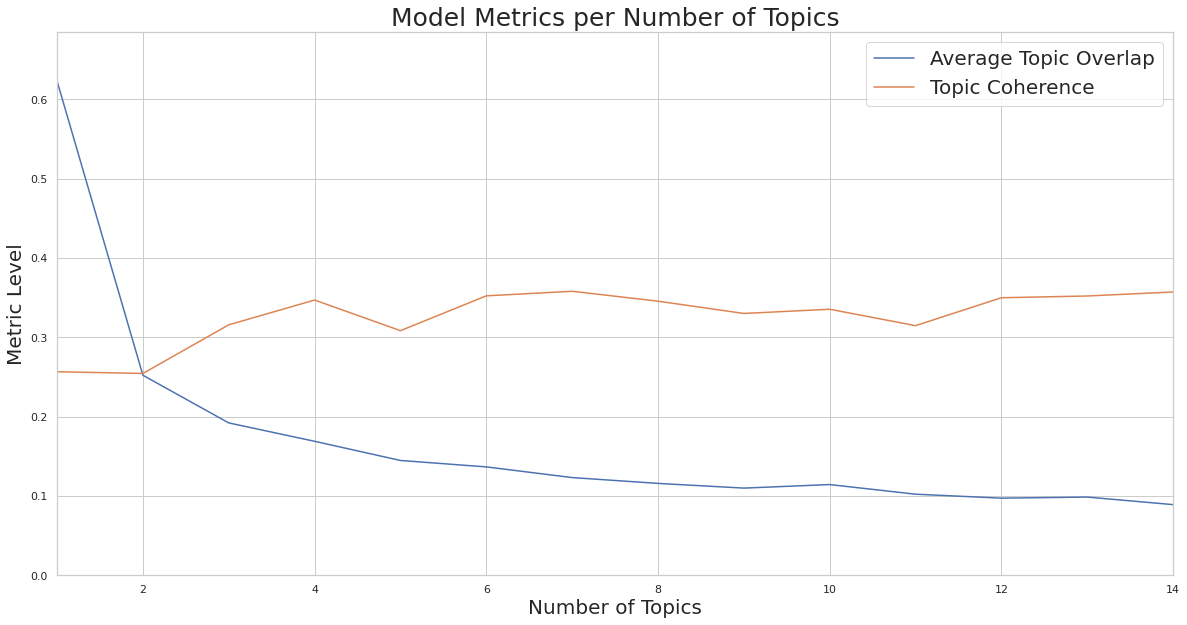

In [ ]:
##run above function to find optimal topic number 

id2word = corpora.Dictionary(data_lemmatized)

# Filter out extremes to limit the number of features
id2word.filter_extremes(no_below=15, no_above=0.85, keep_n=5000)

# Create the bag-of-words format (list of (token_id, token_count))
bow_corpus = [id2word.doc2bow(text) for text in data_lemmatized]

opt_topic_num_nmf(id2word, bow_corpus)

# Part F: Find optimal number of topics by plotting divergence between Jaccard similarity and Coherence for BTM

100%|██████████| 193/193 [00:00<00:00, 414.94it/s]


mean_stabilities: [0.6718266253869969, 0.6064436939049942, 0.6028722701895403, 0.5874064702852225, 0.5674633815803557, 0.5416721712608488, 0.545964674875567, 0.49449995787981504, 0.4690063845965269, 0.46499079476645894, 0.46155447477439615, 0.45749584787632147, 0.4710469308924613, 0.45512688852049077]
coherences: [-26.94650375830322, -11.026613808042075, -14.198821966535403, -18.51905800761504, -18.122264912227756, -19.68893563792011, -10.714337160588327, -8.252746543294188, -18.903953260411907, -24.154612354416162, -18.633821363081953, -22.07894866796943, -22.883281546682095, -18.736178569068812]
perplexities: [1374.4019072259712, 1358.1454873681075, 1356.3114528201622, 1351.8626513643321, 1347.3578331753054, 1348.7618633999593, 1347.0172941816759, 1346.9227546767934, 1342.654704903055, 1339.8808043123095, 1340.506022367994, 1338.6003097088656, 1340.6674786163476, 1340.385039697643]


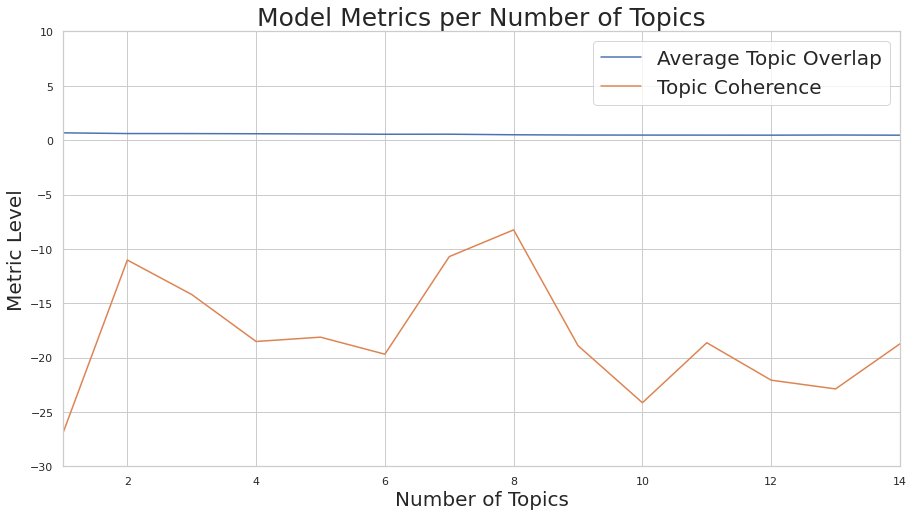

In [ ]:
def opt_topic_num_btm(texts, stop_words):
  '''
  function to find optimal topic number for btm model
  '''
  # Considering 1-15 topics, as the last is cut off
  num_topics = list(range(16)[1:])
  num_keywords = 15

  X, vocabulary, vocab_dict = btm.get_words_freqs(texts, stop_words=stop_words)
  docs_vec = btm.get_vectorized_docs(texts, vocabulary)
  biterms = btm.get_biterms(docs_vec)

  btm_models = {}
  btm_topics = {}
  for i in num_topics:
      btm_models[i] = btm.BTM(X, vocabulary, seed=12321, T=i, M=20, alpha=50/8, beta=0.01)
      btm_models[i].fit(biterms, iterations=20)

      p_zd = btm_models[i].transform(docs_vec)

      top_words = btm.get_top_topic_words(btm_models[i],words_num=num_keywords)
      btm_topics[i] = top_words.T.values.tolist()

  btm_stability = {}
  for i in range(0, len(num_topics)-1):
      jaccard_sims = []
      for t1, topic1 in enumerate(btm_topics[num_topics[i]]): # pylint: disable=unused-variable
          sims = []
          for t2, topic2 in enumerate(btm_topics[num_topics[i+1]]): # pylint: disable=unused-variable
              sims.append(jaccard_similarity(topic1, topic2))    
          
          jaccard_sims.append(sims)    
      
      btm_stability[num_topics[i]] = jaccard_sims
                  
  mean_stabilities = [np.array(btm_stability[i]).mean() for i in num_topics[:-1]]
  
  coherences = [np.mean(btm_models[i].coherence_) for i in num_topics[:-1]]

  perplexities = [btm_models[i].perplexity_ for i in num_topics[:-1]]

  print('mean_stabilities:', mean_stabilities)
  print('coherences:', coherences)
  print('perplexities:', perplexities)

  plt.figure(figsize=(15,8))
  ax = sns.lineplot(x=num_topics[:-1], y=mean_stabilities, label='Average Topic Overlap')
  ax = sns.lineplot(x=num_topics[:-1], y=coherences, label='Topic Coherence')

  ax.set_ylim([-30, 10])
  ax.set_xlim([1, num_topics[-1]-1])
                  
  ax.axes.set_title('Model Metrics per Number of Topics', fontsize=25)
  ax.set_ylabel('Metric Level', fontsize=20)
  ax.set_xlabel('Number of Topics', fontsize=20)
  plt.legend(fontsize=20)
  plt.show()   

#run function
texts = [' '.join(i) for i in data_lemmatized]
opt_topic_num_btm(texts, stop_words=None)


In [ ]:
btm_coherences = [-26.94650375830322, -11.026613808042075, -14.198821966535403, -18.51905800761504, -18.122264912227756, -19.68893563792011, -10.714337160588327, -8.252746543294188, -18.903953260411907, -24.154612354416162, -18.633821363081953, -22.07894866796943, -22.883281546682095, -18.736178569068812]
btm_perplex=[1374.4019072259712, 1358.1454873681075, 1356.3114528201622, 1351.8626513643321, 1347.3578331753054, 1348.7618633999593, 1347.0172941816759, 1346.9227546767934, 1342.654704903055, 1339.8808043123095, 1340.506022367994, 1338.6003097088656, 1340.6674786163476, 1340.385039697643]

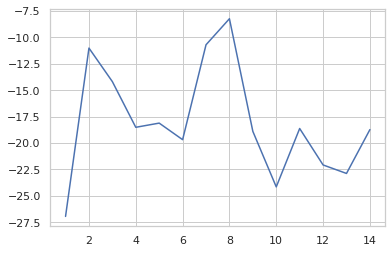

In [ ]:
x = range(1, 15)
plt.plot(x,btm_coherences)

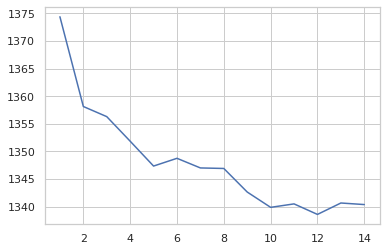

In [ ]:
x = range(1, 15)
plt.plot(x,btm_perplex)

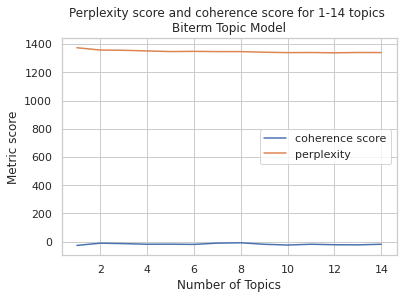

In [ ]:

x = range(1, 15)
plt.plot(x, btm_coherences, label='coherence score')
plt.plot(x, btm_perplex, label='perplexity')
plt.xlabel("Number of Topics")
plt.ylabel("Metric score")
plt.legend(loc="best")
plt.title('Perplexity score and coherence score for 1-14 topics \nBiterm Topic Model')
plt.show()

# Part F: Run Preliminary topic models  
From the optimal topic numbers for LDA, NMF, and BTM, I estimate the optimal topic number is somewhere between 5-9. I thus run preliminary topic models using LDA, NMF, and BTM for 5 and 9 topics to determine whether further preprocessing of the text is needed and to decide on an appropriate topic model. 

## Part F1: Run LDA topic models for topic num 5, 9 

In [ ]:
def run_lda(corpus, id2word, num_topics): 
  lda_model = gensim.models.ldamodel.LdaModel(
      corpus=corpus,    # Stream of document vectors or sparse matrix of shape (num_terms, num_documents)
      id2word=id2word,  # It is used to determine the vocabulary size, as well as for debugging and topic printing.
      num_topics=num_topics,    # The number of requested latent topics to be extracted from the training corpus.
      random_state=100, # Useful for reproducibility.
      update_every=1,   # Set to 0 for batch learning, > 1 for online iterative learning.How often model parameters should be updated 
      chunksize=100,    # Number of documents to be used in each training chunk.
      passes=10,        # Number of passes through the corpus during training.
      alpha='auto',     # auto: Learns an asymmetric prior from the corpus Hyperparameter that affect sparsity of topics 
      per_word_topics=True 
      # If True, the model also computes a list of topics, sorted in descending order of most likely topics for each word,
      # along with their phi values multiplied by the feature-length (i.e. word count)
  )

  #pprint(lda_model.print_topics()) #unhash this version if you want to see probabilities for each of the words 
  for j, (topic_num, prop_topic) in enumerate(lda_model.print_topics()):
    wp = lda_model.show_topic(topic_num)
    topic_keywords = ", ".join([word for word, prop in wp])
    print('Topic', topic_num, ':', topic_keywords)
    


In [ ]:
#No names removed from dataset
id2word = corpora.Dictionary(data_lemmatized)
texts = data_lemmatized #creates corpus
corpus = [id2word.doc2bow(text) for text in texts] #term doc frequency 

for i in [5, 9]: 
  print('LDA topic model for', i, 'topics (key character NOT names removed):')
  run_lda(corpus, id2word, i)
  print('\n')

LDA topic model for 5 topics (key character NOT names removed):
Topic 0 : say, would, know, look, think, lady, hyacinth, could, ask, smile
Topic 1 : penelope, eloise, whistledown, know, say, write, paper, would, nurse, think
Topic 2 : say, know, would, could, think, want, look, go, feel, eye
Topic 3 : midwife, ohhhhhhh, matchmaker, fret, nursemaid, investment, deduct, digit, digits, unawares
Topic 4 : say, sophie, posy, ball, rosamund, water, look, go, magistrate, penwood


LDA topic model for 9 topics (key character NOT names removed):
Topic 0 : say, penelope, lady, hyacinth, know, would, mother, think, look, smile
Topic 1 : duke, nurse, duchess, basset, heir, briarly, son, pregnancy, castle, dukedom
Topic 2 : say, know, would, could, go, think, want, feel, look, eye
Topic 3 : say, think, could, would, know, look, penelope, go, make, even
Topic 4 : magistrate, cell, penwood, posy, sophie, warden, theft, clip, bar, rat
Topic 5 : terrace, thimble, scone, mending, tonic, music, mask, bal

In [ ]:
#remove key names from data_lemmatized

new_data_lemma = []
for chapt in data_lemmatized:
  for word in chapt: 
    if word in key_names: 
      chapt.remove(word)
  new_data_lemma.append(chapt)

#run lda with key names removed 
id2word = corpora.Dictionary(new_data_lemma)
texts = new_data_lemma #creates corpus
corpus = [id2word.doc2bow(text) for text in texts] #term doc frequency 

for i in [5, 9]: 
  print('LDA topic model for', i, 'topics (key character names removed):')
  run_lda(corpus, id2word, i)
  print('\n')



LDA topic model for 5 topics (key character names removed):
Topic 0 : say, would, know, look, think, could, go, ask, lady, even
Topic 1 : say, know, would, could, want, feel, think, eye, go, look
Topic 2 : say, kiss, finger, want, hand, would, skin, feel, lip, rosamund
Topic 3 : say, child, nurse, go, look, take, know, even, time, think
Topic 4 : breast, charge, desire, slide, cupping, chemise, body, writhe, command, whisper


LDA topic model for 9 topics (key character names removed):
Topic 0 : say, would, know, look, think, could, go, even, ask, see
Topic 1 : say, know, eye, look, make, hand, think, see, could, would
Topic 2 : rosamund, shoe, gibbon, silver, glove, crest, masquerade, gown, pin, ball
Topic 3 : ball, water, wicket, mallet, lake, ile, mall, pall, pink, ought
Topic 4 : say, know, look, go, could, think, make, want, never, hand
Topic 5 : say, look, know, would, think, feel, could, even, see, eye
Topic 6 : ungainly, pvermuch, editor, scribbling, added, smiling, say, look, 

## Part F2: Run NMF topic models for topic num 5, 9 
code adapted from: https://github.com/robsalgado/personal_data_science_projects/blob/master/topic_modeling_nmf/topic_modeling_cnn.ipynb

In [ ]:
def run_nmf(texts, use_stop, best_num_topics, words_to_show): 
  '''
  function producing nmf topic model topics
  '''

  if use_stop: 
    # Convert a collection of raw documents to a matrix of TF-IDF features
    tfidf_vectorizer = TfidfVectorizer(
        min_df=15, #ignore terms that have a document frequency strictly lower than the given threshold
        max_df=0.85, #ignore terms that have a document frequency strictly higher than the given threshold
        max_features=5000,
        stop_words= key_names,
        preprocessor=' '.join
    )
  else: 
    tfidf_vectorizer = TfidfVectorizer(
        min_df=15, 
        max_df=0.85, 
        max_features=5000,
        preprocessor=' '.join)

  
  tfidf = tfidf_vectorizer.fit_transform(texts) #returns (document_id, token_id) and value following the tuple represents the tf-idf score of a given token in a given document

  # Save the feature names for later to create topic summaries
  tfidf_fn = tfidf_vectorizer.get_feature_names()

  # Run the nmf model
  nmf = NMF(
      n_components=best_num_topics,
      init='nndsvd',
      max_iter=500,
      l1_ratio=0.0,
      solver='cd',
      alpha=0.0,
      tol=1e-4).fit(tfidf)

  W = nmf.fit_transform(tfidf)
  H = nmf.components_
  words = np.array(tfidf_vectorizer.get_feature_names())

  for i, topic in enumerate(H):
      print("Topic {}: {}".format(i + 1, ",".join([str(x) for x in words[topic.argsort()[words_to_show:]]])))
  

In [ ]:
for i in [5, 9]: 
  print('NMF topic model for ', i, 'topics (key character names removed):')
  run_nmf(texts=data_lemmatized, use_stop=True, best_num_topics=i, words_to_show=-10)
  
  print('\n\nNMF topic model for ', i, 'topics (key character names NOT removed):')
  run_nmf(texts=data_lemmatized, use_stop=False, best_num_topics=i, words_to_show=-10)

  print('\n\n')

NMF topic model for  5 topics (key character names removed):
Topic 1: believe,nod,shall,evening,reply,marry,sort,dance,sister,brother
Topic 2: bed,pull,breast,touch,skin,slide,body,finger,kiss,whisper
Topic 3: money,dance,girl,countess,people,cane,book,read,grandmother,lady
Topic 4: rain,wife,door,die,sit,twin,bed,nurse,father,child
Topic 5: call,young,sister,marry,girl,child,daughter,family,tea,mother


NMF topic model for  5 topics (key character names NOT removed):
Topic 1: francesca,brother,kiss,whisper,child,anthony,hermione,phillip,gregory,eloise
Topic 2: dance,write,people,mother,felicity,whistledown,danbury,eloise,lady,penelope
Topic 3: grace,young,body,brother,child,duke,mother,violet,anthony,daphne
Topic 4: jewel,father,book,mother,violet,lady,danbury,grandmother,gareth,hyacinth
Topic 5: girl,servant,shoe,violet,mother,lady,penwood,posy,sophie,benedict



NMF topic model for  9 topics (key character names removed):
Topic 1: friend,actually,conversation,reply,shall,evening,sor

## Part F3: Run BTM for topic num 5, 9 

In [ ]:
def run_btm(texts, use_stop, best_num_topics): 
  '''
  function producing btm topics
  '''
  if use_stop: 
    stop_words = key_names
    X, vocabulary, vocab_dict = btm.get_words_freqs(texts,  stop_words=stop_words)
    tf = np.array(X.sum(axis=0)).ravel()
    # Vectorizing documents
    docs_vec = btm.get_vectorized_docs(texts, vocabulary)
    docs_lens = list(map(len, docs_vec))
    # Generating biterms
    biterms = btm.get_biterms(docs_vec)

    model = btm.BTM(X, vocabulary, seed=12321, T=best_num_topics, M=20, alpha=50/8, beta=0.01)
    model.fit(biterms, iterations=20)
    p_zd = model.transform(docs_vec)

    display(btm.get_top_topic_words(model,words_num=10).T)


  else: 
    X, vocabulary, vocab_dict = btm.get_words_freqs(texts)
    tf = np.array(X.sum(axis=0)).ravel()
    # Vectorizing documents
    docs_vec = btm.get_vectorized_docs(texts, vocabulary)
    docs_lens = list(map(len, docs_vec))
    # Generating biterms
    biterms = btm.get_biterms(docs_vec)

    model = btm.BTM(X, vocabulary, seed=12321, T=best_num_topics, M=20, alpha=50/8, beta=0.01)
    model.fit(biterms, iterations=20)
    p_zd = model.transform(docs_vec)
    display(btm.get_top_topic_words(model,words_num=10).T)


In [ ]:
texts = [' '.join(i) for i in data_lemmatized]

for i in [5, 9]: 
  print('BTM for ', i, 'topics (key character names removed):')
  run_btm(texts, use_stop=True, best_num_topics=i)
  
  print('\n\nBTM for ', i, 'topics (key character names NOT removed):')
  run_btm(texts, use_stop=False, best_num_topics=i)

  print('\n\n')

BTM for  5 topics (key character names removed):


100%|██████████| 193/193 [00:00<00:00, 829.78it/s]


0      1      2      3      4      5     6      7      8     9
topic0  say   know  would   look  think  could  even     go    eye   see
topic1  say  would   know  think  could   even  make   lady  never    go
topic2  say   look  would   know  think     go   ask  could    see  turn
topic3  say   hand   know   feel    eye  could  want   look    lip  back
topic4  say  would   know  think  could   look    go   make    ask  want



BTM for  5 topics (key character names NOT removed):


100%|██████████| 193/193 [00:00<00:00, 870.93it/s]


0      1      2      3      4      5      6     7     8      9
topic0  say  would   know   look  could  think   make    go  take    see
topic1  say  would   know   look  think    ask  could    go  make   lady
topic2  say   hand  could   know   feel    eye   want    go  look  would
topic3  say   know  would  could  think   want   look    go  even   feel
topic4  say  would   know  think   look  could  never  even    go   make




BTM for  9 topics (key character names removed):


100%|██████████| 193/193 [00:00<00:00, 604.23it/s]


0      1      2      3      4      5      6       7      8      9
topic0  say  would   know  think   look   lady   even     ask  could  never
topic1  say   know    eye   look  would  could   feel    want   even   hand
topic2  say  would   know  think  could   make   lady  mother     go   look
topic3  say  would   know  could     go  think   even    look    see   make
topic4  say   look  would  think   know     go    ask    take   turn    eye
topic5  say   hand   feel    lip   know  could   look     eye   want  think
topic6  say   know   want  could   feel    eye  would    look   hand   make
topic7  say  would   know  think  could   look   make     see     go   time
topic8  say  would   know     go  think   look  could    make    ask   even



BTM for  9 topics (key character names NOT removed):


100%|██████████| 193/193 [00:00<00:00, 585.64it/s]


0      1      2      3      4       5      6       7      8       9
topic0  say   look  would   room  think   could   take      go    see    know
topic1  say   know  would   look  could    even   feel     eye   make   think
topic2  say   know  would  think   look   could    ask   never   make     eye
topic3  say   look   know     go  would   could    ask   think    eye    back
topic4  say   look     go   know  would   could  think     eye    see    want
topic5  say   know  would  could  think    want     go    make   feel    look
topic6  say  would   know  think   look      go   even  mother  could    time
topic7  say   hand   feel  could   want     lip   know     eye   even  finger
topic8  say  would   know  think   lady  mother   look   never  could      go

# Part G: From preliminary topic models I decide to use NMF topic modeling and determined it will be a good idea to replace protagonist names with normalized versions of the name (i.e. male_lead, female_lead)

## Part G1: replace names with normalized versions of the name 

In [ ]:
norm_names = pd.read_excel('normalized_names.xlsx')
norm_names.head(20)

book                norm           name
0   bk1         female_lead         daphne
1   bk1           male_lead           duke
2   bk1           male_lead          simon
3   bk1           male_lead         basset
4   bk1   bridgerton_father         edmund
5   bk1   bridgerton_mother         violet
6   bk1  bridgerton_brother        anthony
7   bk1  bridgerton_brother       benedict
8   bk1  bridgerton_brother          colin
9   bk1  bridgerton_brother        gregory
10  bk1   bridgerton_sister         eloise
11  bk1   bridgerton_sister      francesca
12  bk1   bridgerton_sister       hyacinth
13  bk1        high_society       penelope
14  bk1        high_society         portia
15  bk1        high_society  featherington
16  bk1        high_society       philippa
17  bk1        high_society       felicity
18  bk1        high_society       prudence
19  bk1        high_society        danbury

In [ ]:
bk1_df = norm_names[norm_names['book']=='bk1'].copy()
bk2_df = norm_names[norm_names['book']=='bk2'].copy()
bk3_df = norm_names[norm_names['book']=='bk3'].copy()
bk4_df = norm_names[norm_names['book']=='bk4'].copy()
bk5_df = norm_names[norm_names['book']=='bk5'].copy()
bk6_df = norm_names[norm_names['book']=='bk6'].copy()
bk7_df = norm_names[norm_names['book']=='bk7'].copy()
bk8_df = norm_names[norm_names['book']=='bk8'].copy()

bks_list = [bk1_df, bk2_df, bk3_df, bk4_df, bk5_df, bk6_df, bk7_df, bk8_df]

In [ ]:
char_dict = {}

for count, bk in enumerate(bks_list): 
  temp_dict ={}
  for index, row in bk.iterrows():
    temp_dict[row['name']] = row['norm']
    char_dict[count] = temp_dict

In [ ]:
char_dict

{0: {'anthony': 'bridgerton_brother',
  'basset': 'male_lead',
  'benedict': 'bridgerton_brother',
  'berbrooke': 'high_society',
  'colin': 'bridgerton_brother',
  'cressida': 'high_society',
  'danbury': 'high_society',
  'daphne': 'female_lead',
  'duke': 'male_lead',
  'edmund': 'bridgerton_father',
  'eloise': 'bridgerton_sister',
  'featherington': 'high_society',
  'felicity': 'high_society',
  'francesca': 'bridgerton_sister',
  'gregory': 'bridgerton_brother',
  'hyacinth': 'bridgerton_sister',
  'nigel': 'high_society',
  'penelope': 'high_society',
  'penwood': 'high_society',
  'philippa': 'high_society',
  'portia': 'high_society',
  'prudence': 'high_society',
  'simon': 'male_lead',
  'violet': 'bridgerton_mother',
  'whistledown': 'high_society'},
 1: {'anthony': 'male_lead',
  'benedict': 'bridgerton_brother',
  'berbrooke': 'high_society',
  'colin': 'bridgerton_brother',
  'cressida': 'high_society',
  'danbury': 'high_society',
  'daphne': 'bridgerton_sister',
  'ed

In [ ]:
def lemmatization1(texts, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']):
    texts = ' '.join(texts)
    doc = nlp(texts)
    return [token.lemma_ for token in doc if token.pos_ in allowed_postags]

In [ ]:
#clean each of the books and replace the key names with normalized versions of the name 

for count, book in enumerate(bk_dfs): 
  #remove punctuation and change text to lower case 
  book['text'] = \
  book['text'].map(lambda x: re.sub('[,\.!?]', '', x))
  book['text'] = \
  book['text'].map(lambda x: x.lower())

  book['remove_punct'] = book['text'].apply(lambda x: gensim.utils.simple_preprocess(str(x), deacc=True))
  book['remove_stop'] = book['remove_punct'].apply(lambda x: [word for word in simple_preprocess(str(x)) if word not in stop_words])
  book['lemmatize'] = book['remove_stop'].apply(lambda x: lemmatization1(x)).apply(' '.join)

  char_pattern = {r'(\b){}(\b)'.format(k):r'\1{}\2'.format(v) for k,v in char_dict[count].items()}
  book['re_text']= book['lemmatize'].replace(char_pattern, regex=True)
  display(book.head(2))



book_num  ...                                            re_text
0         1  ...  birth meet great celebration church bell hour ...
1         1  ...  bridgerton far prolific family industriousness...

[2 rows x 8 columns]

book_num  ...                                            re_text
0         2  ...  season open year little reason hope see notice...
1         2  ...  topic rake course previously discuss column au...

[2 rows x 8 columns]

book_num  ...                                            re_text
0         3  ...  season well way would think talk would waterlo...
1         3  ...  year seek invitation must surely hold next ind...

[2 rows x 8 columns]

book_num  ...                                            re_text
0         4  ...  nearly new social season ambitious find dress ...
1         4  ...  return gentle ignorant reader town year legend...

[2 rows x 8 columns]

book_num  ...                                            re_text
0         5  ...  gloucestershire really happen sunny day first ...
1         5  ...  may somewhere road gloucestershire thank kind ...

[2 rows x 8 columns]

book_num  ...                                            re_text
0         6  ...  call jolly good time bad woman woman bind make...
1         6  ...  bad suspect would tell woman least try make su...

[2 rows x 8 columns]

book_num  ...                                            re_text
0         7  ...  year story begin earnest principle govern rely...
1         7  ...  year pass meet heroine must say never know shy...

[2 rows x 8 columns]

book_num  ...                                            re_text
0         8  ...  far summer lung fire run street oblivious curi...
1         8  ...  love month earlier man believe true love fool ...

[2 rows x 8 columns]

In [ ]:
all_bks2_df = pd.concat(bk_dfs)
all_bks2_df

book_num  ...                                            re_text
0          1  ...  birth meet great celebration church bell hour ...
1          1  ...  bridgerton far prolific family industriousness...
2          1  ...  hasting interesting character common knowledge...
3          1  ...  see purchase far lady society paper night fema...
4          1  ...  last week author see few determine bachelor co...
..       ...  ...                                                ...
22         8  ...  hell break loose break loose charge brother tr...
23         8  ...  hero risk year become never know host party sm...
24         8  ...  leave awkward position tying water closet say ...
25         8  ...  learn happen mere minute early hour surely hou...
26         8  ...  industriousness know capable first time male_l...

[193 rows x 8 columns]

In [ ]:
data2 = all_bks2_df.re_text.values.tolist() 

stop_words.append('bridgerton')
stop_words.append('lady')

In [ ]:
data_lemmatized2 = [chapt.split( ) for chapt in data2]
data_lemmatized2 = remove_stopwords(data_lemmatized2)

## Part G2: Run NMF Jaccard and Coherence again to find optimal topic number with newly preprocessed text 

ideal_topic_num (when maxing divergence): 14
mean_stabilities: [0.6718266253869969, 0.5048416495784916, 0.47041372370319734, 0.4450878926565426, 0.4040639312378443, 0.36700096514578373, 0.2665560543666134, 0.1752501332398884, 0.14440575763046107, 0.11991105463476937, 0.10850174502221087, 0.10338282094795033, 0.08838197972586823, 0.08390041817649442]
coherences: [0.20843305630158065, 0.20608960509682445, 0.21656576596588017, 0.22106815913427666, 0.2186301911261565, 0.21779468485656125, 0.23029295358814925, 0.26580833559010175, 0.3049522698328338, 0.32659651726069994, 0.3243310137854707, 0.3241235200783709, 0.3218926491291389, 0.31962082064411673]


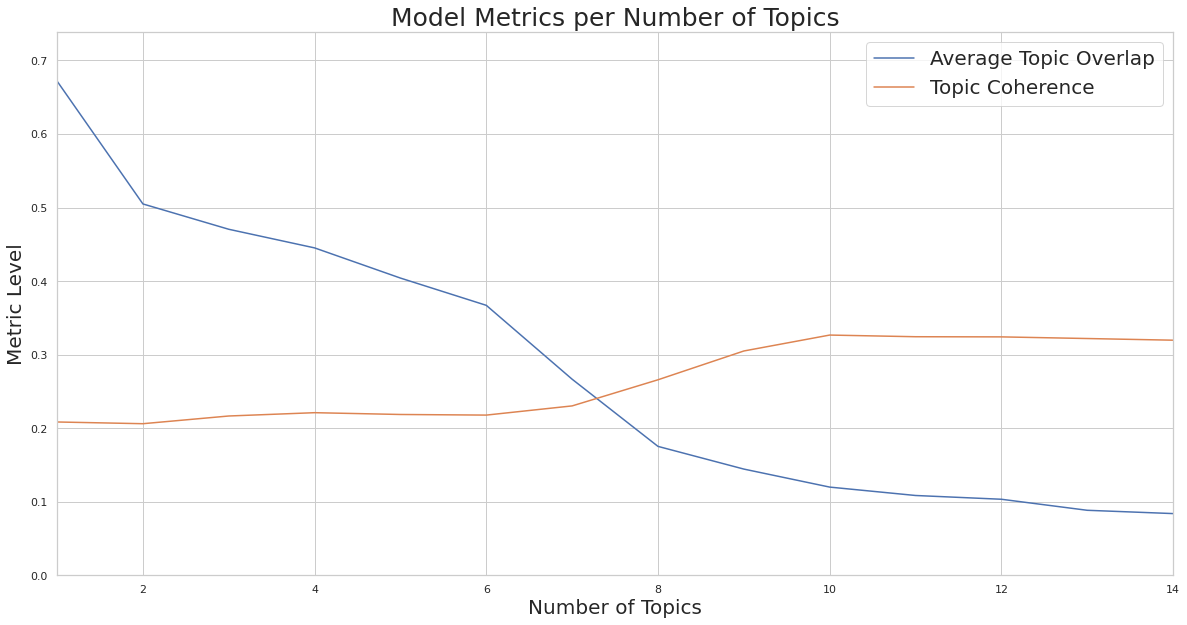

In [ ]:
##run above function to find optimal topic number 
id2word = corpora.Dictionary(data_lemmatized2)

# Filter out extremes to limit the number of features
id2word.filter_extremes(no_below=15, no_above=0.85, keep_n=5000)

# Create the bag-of-words format (list of (token_id, token_count))
bow_corpus = [id2word.doc2bow(text) for text in data_lemmatized]

opt_topic_num_nmf(id2word, bow_corpus)

## Part G3: Run NMF with 8 topics

In [ ]:
print('NMF topic model for 8 topics (key names removed and NOT normalized):')
run_nmf(texts=data_lemmatized, use_stop=True, best_num_topics=8, words_to_show=-15)


print('\n\nNMF topic model for 8 topics (key names normalized):')
run_nmf(texts=data_lemmatized2, use_stop=False, best_num_topics=8, words_to_show=-15)

NMF topic model for 8 topics (key names removed and NOT normalized):
Topic 1: believe,suppose,friend,perhaps,marry,conversation,actually,reply,viscount,shall,evening,sort,dance,sister,brother
Topic 2: murmur,bed,gasp,breath,moan,pull,desire,touch,skin,breast,slide,whisper,body,finger,kiss
Topic 3: identity,crowd,column,author,society,old,attention,money,dance,ballroom,cane,countess,people,girl,lady
Topic 4: forehead,morning,water,cold,cough,fever,thunder,night,die,sit,cottage,sleep,storm,bed,rain
Topic 5: meet,husband,shoe,week,young,sister,call,shall,marry,girl,child,family,daughter,tea,mother
Topic 6: glance,murmur,work,desk,sit,lady,finger,kiss,jewel,write,father,page,read,book,grandmother
Topic 7: expect,sit,talk,mother,bed,suppose,letter,marriage,wife,son,sir,twin,father,nurse,child
Topic 8: understand,hurt,brother,speak,cry,window,marry,stare,run,wedding,step,door,whisper,carriage,church


NMF topic model for 8 topics (key names normalized):
Topic 1: certainly,suitor,conversation

In [ ]:
tfidf_vectorizer = TfidfVectorizer(
    min_df=15, 
    max_df=0.85, 
    max_features=5000,
    preprocessor=' '.join)


tfidf = tfidf_vectorizer.fit_transform(data_lemmatized2) #returns (document_id, token_id) and value following the tuple represents the tf-idf score of a given token in a given document

# Save the feature names for later to create topic summaries
tfidf_fn = tfidf_vectorizer.get_feature_names()

# Run the nmf model
nmf = NMF(
  n_components=8,
  init='nndsvd',
  max_iter=500,
  l1_ratio=0.0,
  solver='cd',
  alpha=0.0,
  tol=1e-4).fit(tfidf)

W = nmf.fit_transform(tfidf)
H = nmf.components_
words = np.array(tfidf_vectorizer.get_feature_names())

for i, topic in enumerate(H):
      print("Topic {}: {}".format(i , ",".join([str(x) for x in words[topic.argsort()[-15:]]])))


Topic 0: certainly,suitor,conversation,rake,actually,decide,reply,drink,dance,evening,flower,marry,sort,brother,sister
Topic 1: friend,breakfast,young,bad,expression,girl,music,brother,attention,sister,else,ballroom,people,dance,high_society
Topic 2: reply,pull,water,nod,dream,son,step,watch,door,hour,young,servant,father,brother,male_lead
Topic 3: murmur,hip,gasp,breath,pull,moan,desire,touch,skin,slide,breast,whisper,body,finger,kiss
Topic 4: age,husband,marry,author,call,week,biscuit,society,shoe,girl,child,family,daughter,tea,mother
Topic 5: desk,glance,finger,sit,father,murmur,kiss,jewel,cane,countess,write,page,read,book,grandmother
Topic 6: sit,expect,wife,talk,letter,mother,marriage,bed,suppose,sir,male_lead,father,twin,nurse,child
Topic 7: heart,body,die,sleep,night,sit,window,cry,run,storm,door,carriage,rain,whisper,bed


In [ ]:
# Find topic distributions for each chapter of the book 
tfidf_new = tfidf_vectorizer.transform(data_lemmatized2)
topic_probability_scores = nmf.transform(tfidf_new)

all_bks2_df['pred_topic_num'] = topic_probability_scores.argmax(axis=1)+1
all_bks2_df['respective_topic_prob'] = [np.sort(i)[-1] for i in topic_probability_scores]

In [ ]:
pd.DataFrame(topic_probability_scores, columns=[1,2,3,4,5,6,7,8])

1         2         3  ...         6         7         8
0    0.000000  0.000000  0.095333  ...  0.000000  0.321247  0.000000
1    0.038643  0.143438  0.002745  ...  0.027717  0.055569  0.000000
2    0.107993  0.163066  0.116219  ...  0.015825  0.033698  0.000000
3    0.176998  0.034196  0.067094  ...  0.002360  0.000000  0.090573
4    0.104688  0.209588  0.009970  ...  0.000000  0.000000  0.000000
..        ...       ...       ...  ...       ...       ...       ...
188  0.000000  0.020363  0.222244  ...  0.000000  0.000000  0.176736
189  0.082874  0.069846  0.114016  ...  0.000000  0.000000  0.218841
190  0.018298  0.173138  0.261365  ...  0.001836  0.012472  0.127188
191  0.000000  0.054744  0.278735  ...  0.004494  0.000000  0.230856
192  0.000000  0.000000  0.119995  ...  0.000000  0.271613  0.000000

[193 rows x 8 columns]

In [ ]:
topic_dist_bks = all_bks2_df[['book_num','title','chapter','pred_topic_num', 'respective_topic_prob']].copy().reset_index().drop(columns=['index'])
topic_dist_bks

book_num                      title  ...  pred_topic_num  respective_topic_prob
0           1             the duke and i  ...               7               0.321247
1           1             the duke and i  ...               5               0.301339
2           1             the duke and i  ...               2               0.163066
3           1             the duke and i  ...               1               0.176998
4           1             the duke and i  ...               2               0.209588
..        ...                        ...  ...             ...                    ...
188         8  on the way to the wedding  ...               3               0.222244
189         8  on the way to the wedding  ...               8               0.218841
190         8  on the way to the wedding  ...               3               0.261365
191         8  on the way to the wedding  ...               3               0.278735
192         8  on the way to the wedding  ...               7               0.271613

[193 rows x 5 columns]

In [ ]:
topic_dist_bks.to_excel('topic distributions.xlsx')

Some analysis into the distribution of topics in the book 

In [ ]:
topic_dist_bks.groupby('pred_topic_num').size()

pred_topic_num
1    24
2    25
3    21
4    22
5    23
6    16
7    18
8    44
dtype: int64

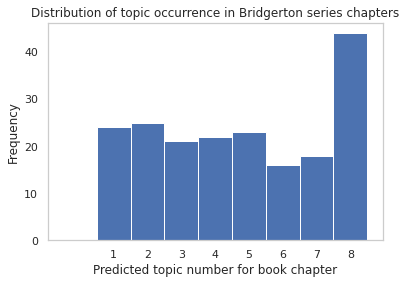

In [ ]:
import matplotlib.ticker as ticker

fig, ax = plt.subplots()
ax.grid(False)
bins= np.arange(10)-0.5
ax.set(xlabel='Predicted topic number for book chapter', ylabel='Frequency')
majors = [1,2,3,4,5,6,7,8]
ax.hist(topic_dist_bks['pred_topic_num'], bins=bins)
ax.yaxis.set_tick_params(labelbottom=True)
ax.xaxis.set_major_locator(ticker.FixedLocator(majors))
ax.tick_params(axis="x")
ax.set_title("Distribution of topic occurrence in Bridgerton series chapters")
plt.show()

In [ ]:
for i in range(topic_dist_bks['chapter'].max()):
  display(topic_dist_bks[topic_dist_bks['chapter']==i])

book_num  ... respective_topic_prob
0           1  ...              0.321076
23          2  ...              0.233191
47          3  ...              0.209685
72          4  ...              0.265915
97          5  ...              0.280899
118         6  ...              0.201501
143         7  ...              0.173277
166         8  ...              0.301526

[8 rows x 5 columns]

book_num  ... respective_topic_prob
1           1  ...              0.301688
24          2  ...              0.162839
48          3  ...              0.238246
73          4  ...              0.388690
98          5  ...              0.143193
119         6  ...              0.317950
144         7  ...              0.347805
167         8  ...              0.266268

[8 rows x 5 columns]

book_num  ... respective_topic_prob
2           1  ...              0.163076
25          2  ...              0.288792
49          3  ...              0.252396
74          4  ...              0.285031
99          5  ...              0.294674
120         6  ...              0.267662
145         7  ...              0.427661
168         8  ...              0.452729

[8 rows x 5 columns]

book_num  ... respective_topic_prob
3           1  ...              0.176925
26          2  ...              0.296564
50          3  ...              0.189565
75          4  ...              0.254904
100         5  ...              0.338858
121         6  ...              0.397417
146         7  ...              0.594331
169         8  ...              0.276055

[8 rows x 5 columns]

book_num  ... respective_topic_prob
4           1  ...              0.209600
27          2  ...              0.152795
51          3  ...              0.268876
76          4  ...              0.226360
101         5  ...              0.273856
122         6  ...              0.278541
147         7  ...              0.310892
170         8  ...              0.260897

[8 rows x 5 columns]

book_num  ... respective_topic_prob
5           1  ...              0.195721
28          2  ...              0.194815
52          3  ...              0.237416
77          4  ...              0.305026
102         5  ...              0.241744
123         6  ...              0.199354
148         7  ...              0.271828
171         8  ...              0.147148

[8 rows x 5 columns]

book_num  ... respective_topic_prob
6           1  ...              0.250669
29          2  ...              0.118107
53          3  ...              0.314012
78          4  ...              0.128846
103         5  ...              0.415835
124         6  ...              0.173355
149         7  ...              0.360299
172         8  ...              0.445276

[8 rows x 5 columns]

book_num  ... respective_topic_prob
7           1  ...              0.205603
30          2  ...              0.168505
54          3  ...              0.336961
79          4  ...              0.381866
104         5  ...              0.336092
125         6  ...              0.262691
150         7  ...              0.208996
173         8  ...              0.220606

[8 rows x 5 columns]

book_num  ... respective_topic_prob
8           1  ...              0.167730
31          2  ...              0.159125
55          3  ...              0.327597
80          4  ...              0.309884
105         5  ...              0.318835
126         6  ...              0.278958
151         7  ...              0.413109
174         8  ...              0.195626

[8 rows x 5 columns]

book_num  ... respective_topic_prob
9           1  ...              0.210356
32          2  ...              0.217922
56          3  ...              0.335964
81          4  ...              0.169831
106         5  ...              0.277712
127         6  ...              0.191100
152         7  ...              0.272548
175         8  ...              0.256800

[8 rows x 5 columns]

book_num  ... respective_topic_prob
10          1  ...              0.248215
33          2  ...              0.122313
57          3  ...              0.195349
82          4  ...              0.465544
107         5  ...              0.178430
128         6  ...              0.232398
153         7  ...              0.227139
176         8  ...              0.231688

[8 rows x 5 columns]

book_num  ... respective_topic_prob
11          1  ...              0.331698
34          2  ...              0.447483
58          3  ...              0.152162
83          4  ...              0.488799
108         5  ...              0.214386
129         6  ...              0.269106
154         7  ...              0.215794
177         8  ...              0.178797

[8 rows x 5 columns]

book_num  ... respective_topic_prob
12          1  ...              0.153251
35          2  ...              0.417909
59          3  ...              0.148345
84          4  ...              0.349614
109         5  ...              0.164532
130         6  ...              0.180479
155         7  ...              0.169571
178         8  ...              0.372558

[8 rows x 5 columns]

book_num  ... respective_topic_prob
13          1  ...              0.250780
36          2  ...              0.227314
60          3  ...              0.277195
85          4  ...              0.214858
110         5  ...              0.279208
131         6  ...              0.204596
156         7  ...              0.499941
179         8  ...              0.148934

[8 rows x 5 columns]

book_num  ... respective_topic_prob
14          1  ...              0.189664
37          2  ...              0.200595
61          3  ...              0.286004
86          4  ...              0.157065
111         5  ...              0.264791
132         6  ...              0.242421
157         7  ...              0.377768
180         8  ...              0.181603

[8 rows x 5 columns]

book_num  ... respective_topic_prob
15          1  ...              0.295579
38          2  ...              0.152719
62          3  ...              0.147424
87          4  ...              0.165458
112         5  ...              0.385368
133         6  ...              0.188537
158         7  ...              0.361888
181         8  ...              0.341733

[8 rows x 5 columns]

book_num  ... respective_topic_prob
16          1  ...              0.243196
39          2  ...              0.197838
63          3  ...              0.226009
88          4  ...              0.210869
113         5  ...              0.419122
134         6  ...              0.380988
159         7  ...              0.334542
182         8  ...              0.220344

[8 rows x 5 columns]

book_num  ... respective_topic_prob
17          1  ...              0.265853
40          2  ...              0.424673
64          3  ...              0.334948
89          4  ...              0.223295
114         5  ...              0.280425
135         6  ...              0.498286
160         7  ...              0.295148
183         8  ...              0.187884

[8 rows x 5 columns]

book_num  ... respective_topic_prob
18          1  ...              0.332388
41          2  ...              0.153552
65          3  ...              0.289225
90          4  ...              0.427415
115         5  ...              0.250691
136         6  ...              0.400001
161         7  ...              0.285883
184         8  ...              0.244933

[8 rows x 5 columns]

book_num  ... respective_topic_prob
19          1  ...              0.173494
42          2  ...              0.435038
66          3  ...              0.248527
91          4  ...              0.169442
116         5  ...              0.155734
137         6  ...              0.248921
162         7  ...              0.482372
185         8  ...              0.304984

[8 rows x 5 columns]

book_num  ... respective_topic_prob
20          1  ...              0.305895
43          2  ...              0.414260
67          3  ...              0.268423
92          4  ...              0.282836
117         5  ...              0.065803
138         6  ...              0.378479
163         7  ...              0.224055
186         8  ...              0.240706

[8 rows x 5 columns]

book_num  ... respective_topic_prob
21          1  ...              0.227944
44          2  ...              0.239147
68          3  ...              0.413398
93          4  ...              0.159157
139         6  ...              0.294265
164         7  ...              0.151313
187         8  ...              0.426311

[7 rows x 5 columns]

book_num  ... respective_topic_prob
22          1  ...              0.121181
45          2  ...              0.354573
69          3  ...              0.207900
94          4  ...              0.279318
140         6  ...              0.428268
165         7  ...              0.178352
188         8  ...              0.222228

[7 rows x 5 columns]

book_num  ... respective_topic_prob
46          2  ...              0.082196
70          3  ...              0.274797
95          4  ...              0.134264
141         6  ...              0.270612
189         8  ...              0.218191

[5 rows x 5 columns]

book_num  ... respective_topic_prob
71          3  ...              0.155352
96          4  ...              0.327017
142         6  ...              0.070716
190         8  ...              0.261346

[4 rows x 5 columns]

book_num                      title  ...  pred_topic_num  respective_topic_prob
191         8  on the way to the wedding  ...               3               0.278715

[1 rows x 5 columns]

## G4: Prep docs for thematic analysis

In [ ]:
#want to create segments of text that are approximately 100 words in length for easier thematic analysis 

all_text = ' '.join(data2)
len(all_text.split())/100 #calculates how many chunks to divide up the text by 

3039.09

In [ ]:
chunks_100words = [' '.join(_chunk) for _chunk in np.array_split(np.asarray(all_text.split()), 3040)]

In [ ]:
chunks_100words[0:2]

['birth meet great celebration church bell hour flow freely gargantuan castle would call home entire village clyvedon quit work partake feast holiday order say ordinary baby would spend life title baby possess name baby could possibly need heir oldest rich dukedom father ninth wait year stand wife confinement cradle heart burst pride already several year forty watch crony male_lead earls beget heir heir suffer daughter sire precious son end assured line would continue blood would pass forward next wife manage conceive time year marriage twice carry full term infant stillborn fifth pregnancy end bloody miscarriage fifth month surgeon physician alike',
 'warn grace absolutely must make attempt child danger frail weak perhaps say gently old simply go reconcile fact dukedom would pass male_lead family duchess bless know role life month recuperative period open connect door bedroom commence son month later duchess informed conceive male_lead immediate elation temper grim determination absol

In [ ]:
data_lemmatized3 = [i.split() for i in chunks_100words] #create list of list of words of the 100 word chunks in anticipation of predicting NMF topic probabilities

In [ ]:
len(chunks_100words[10].split()) #checking the chunks are approx 100 words long 

100

In [ ]:
len(chunks_100words)

3040

In [ ]:
TA_df = pd.DataFrame(chunks_100words, columns=['Text'])
TA_df.head(2)

Text
0  birth meet great celebration church bell hour ...
1  warn grace absolutely must make attempt child ...

In [ ]:
# Find topic distributions for each 100 word chunks 
tfidf_new = tfidf_vectorizer.transform(data_lemmatized3)
topic_probability_scores = nmf.transform(tfidf_new)

topic_prob_df = pd.DataFrame(topic_probability_scores, columns=[1,2,3,4,5,6,7,8])

In [ ]:
pd.concat([TA_df, topic_prob_df], axis=1) #.to_csv('chunks_TA.csv')

Text  ...         8
0     birth meet great celebration church bell hour ...  ...  0.042314
1     warn grace absolutely must make attempt child ...  ...  0.000000
2     place yet pillow wife raise degree angle remai...  ...  0.000000
3     mine want take boy prove finally sire healthy ...  ...  0.000000
4     son shortly visit time time return good second...  ...  0.000000
...                                                 ...  ...       ...
3035  pay passage generous would male_lead mutter wa...  ...  0.000000
3036  long day deserve little indulgence know long w...  ...  0.000000
3037  little still sit door still hold breath hear p...  ...  0.000000
3038  sure enough month seventh sheepishly tell expe...  ...  0.000000
3039  first time would ohhhhhhh male_lead snap back ...  ...  0.000000

[3040 rows x 9 columns]